In [51]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

# Trends

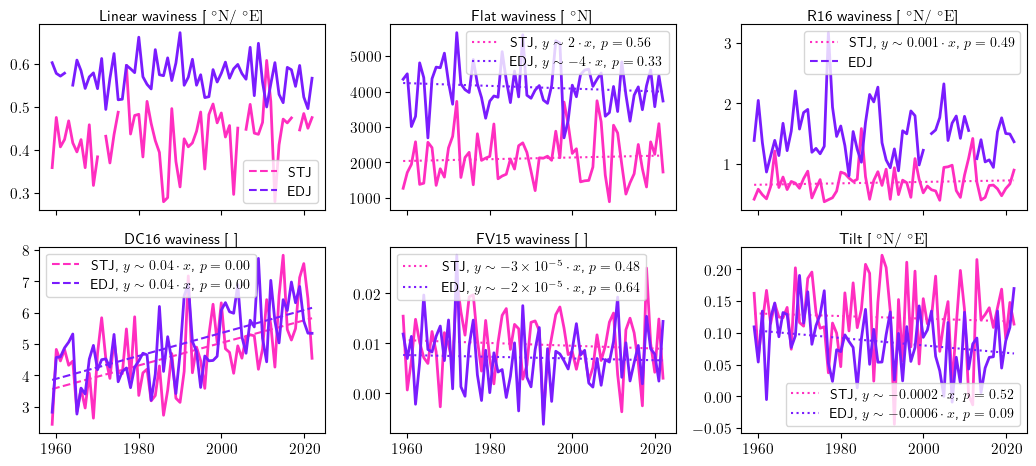

In [53]:
data_vars = [
    "waviness1",
    "waviness2",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "tilt",
]
for season in ["JJA"]:
    plot_trends(
        props_as_df, data_vars, season, nrows=2, ncols=3, clear=False, suffix="_waviness"
    )

In [54]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(props_as_df, data_vars, season, n_boostraps=1000, nrows=4, ncols=4, clear=True)

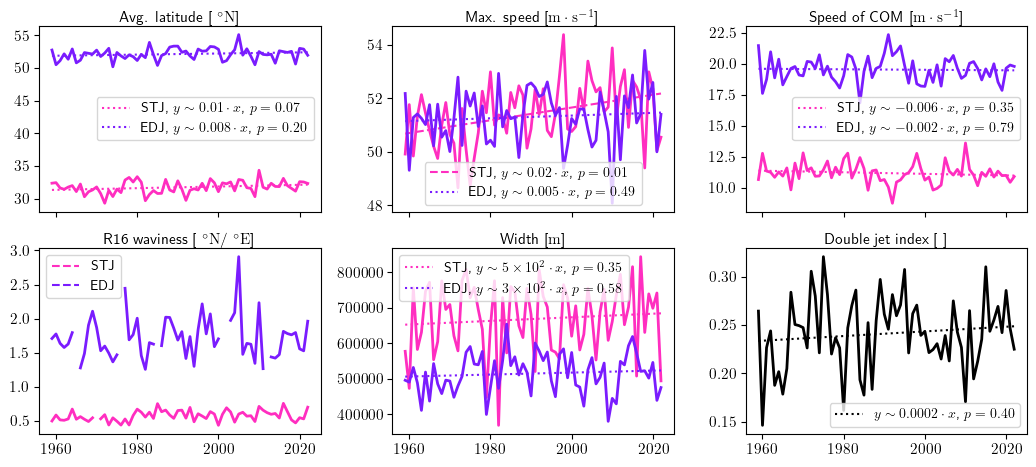

In [55]:
data_vars = [
    "mean_lat",
    "s_star",
    "com_speed",
    "wavinessR16",
    "width",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(
        props_as_df, data_vars, season, n_boostraps=1000, nrows=2, ncols=3, clear=False, suffix="_subset"
    )

In [ ]:
# factors = {
#     "mean_lat": 0.001,
#     "spe_star": 0.01,
#     "com_speed": 0.001,
#     "wavinessR16": 0.0001,
#     "width": 1000,
#     "double_jet_index": 0.0001,
# }
factors = {
    "mean_lon": 0.001,
    "mean_lat": 0.001,
    "mean_lev": 0.01,
    "s_star": 0.01,
    "mean_s": 0.01,
    "tilt": 0.0001,
    "waviness1": 0.0001,
    "wavinessR16": 0.0001,
    "wavinessDC16": 0.0001,
    "wavinessFV15": 0.00001,
    "width": 1000,
    "int": 1e5,
    "int_over_europe": 1e5,
    "persistence": 0.001,
    "com_speed": 0.001,
    "double_jet_index": 0.0001,
}
bootstrap_len = 4
n_boostraps = 10000
data_vars = list(factors)
index_columns = get_index_columns(props_as_df, ("member", "time", "cluster", "jet"))
props_as_df_reduced = props_as_df.filter(pl.col("time").dt.year() >= 1979)
jets = ["STJ", "EDJ"]
seasons = list(SEASONS).copy()
seasons.append("Year")
periods = ["1959-", "1979-"]
iterables = [seasons, periods]


columns = pd.MultiIndex.from_product(iterables, names=["Season", "Period"])
iterables = [[PRETTIER_VARNAME[varname] for varname in data_vars], jets]
index = pd.MultiIndex.from_product(iterables, names=["Property", "Jet"])
df = pd.DataFrame(
    np.zeros((len(index), len(columns)), dtype="str"), index=index, columns=columns
)
# for season in seasons:
#     for reduced, period in zip([False, True], periods):
#         if reduced:
#             pads = props_as_df_reduced
#         else:
#             pads = props_as_df
#         season_ = None if season == "Year" else season
#         if season_ is not None:
#             pads = pads.filter(pl.col("time").dt.month().is_in(SEASONS[season]))
#         pads = (
#             pads[[*index_columns, *data_vars]]
#             .group_by([pl.col("time").dt.year(), pl.col("jet")], maintain_order=True)
#             .mean()
#         )
#         x = pads["time"].unique().to_numpy()
#         for varname, factor in factors.items():
#             for jet in jets:
#                 try:
#                     this_da = pads.filter(pl.col("jet") == jet)[varname]
#                     c1, c0, _, p, _ = linregress(x, this_da.to_numpy())
#                 except KeyError:
#                     this_da = pads[varname]
#                     c1, c0, _, p, _ = linregress(x, this_da.to_numpy())
#                 with warnings.catch_warnings():
#                     warnings.simplefilter(
#                         "ignore", category=pd.errors.PerformanceWarning
#                     )
#                     indexer1 = ((PRETTIER_VARNAME[varname], jet), (season, period))
#                     str_start = r"${" if p > 0.05 else r"$\mathbf{"
#                     str_ = str_start + num2tex(c1 / factor, ncomma=2) + r"}$"
#                     # df.loc[*indexer1] = f"{c1:.2f} ({p:.2f})"
#                     df.loc[*indexer1] = str_
# suffix = "_extended" if len(factors) > 6 else ""
# df.to_latex(
#     buf=f"persistent-extremes-era5/out{suffix}.tex",
#     escape=False,
#     column_format="l",
#     multirow=False,
#     header=True,
#     index_names=False,
# )

# Correlations

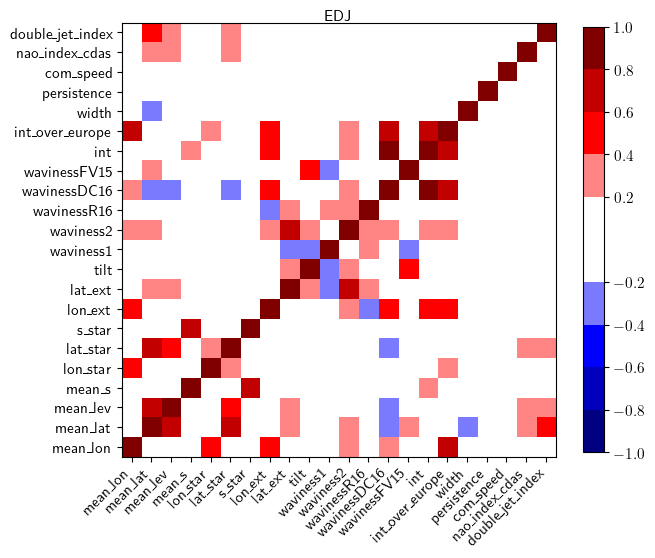

In [61]:
props_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8])).drop("flag")
X = (
    props_summer
    .filter(pl.col("jet") == "EDJ")
    .to_numpy()[:, 2:]
    .astype(float)
)
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
columns = props_summer.columns[2:]
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title("EDJ")
plt.colorbar(im, spacing="proportional", shrink=0.85)

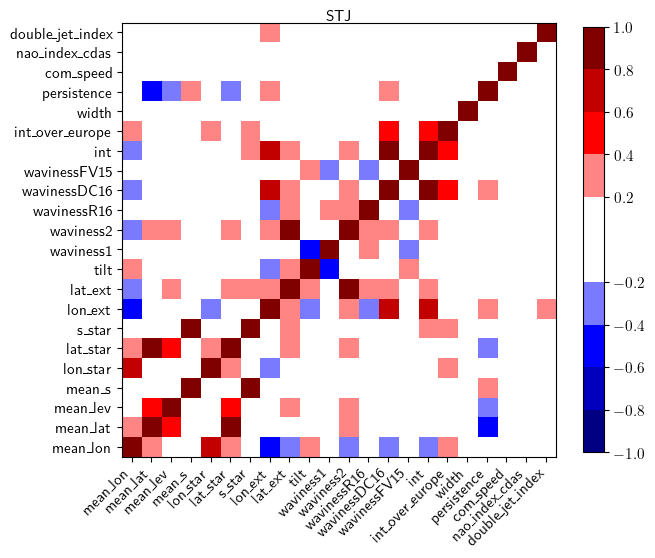

In [62]:
props_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8])).drop("flag")
X = (
    props_summer
    .filter(pl.col("jet") == "STJ")
    .to_numpy()[:, 2:]
    .astype(float)
)
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
columns = props_summer.columns[2:]
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title("STJ")
plt.colorbar(im, spacing="proportional", shrink=0.85)

In [86]:
import polars.selectors as cs

props_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8])).drop("flag")
props_pivoted = (
    props_summer
    .pivot(on="jet", index="time")
    .drop("double_jet_index_STJ", "nao_index_cdas_STJ")
    .rename({f"{vname}_EDJ": f"{vname}" for vname in ["double_jet_index", "nao_index_cdas"]})
)
props_pivoted = props_pivoted.select(pl.col("time"), cs.contains("STJ"), cs.contains("EDJ"), pl.col("double_jet_index"), pl.col("nao_index_cdas"))

Text(0.5, 1.0, 'Merged')

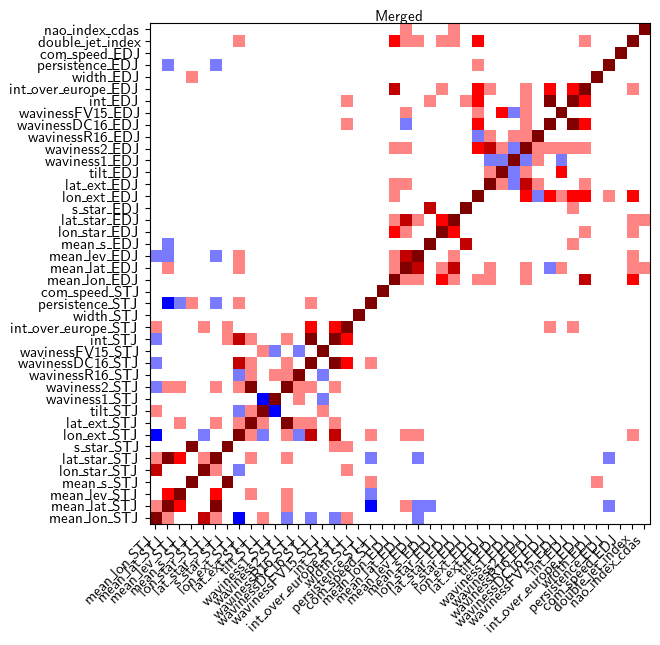

In [87]:
X = props_pivoted.to_numpy()[:, 1:]
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
columns = props_pivoted.columns[1:]
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title("Merged")

Text(0.5, 1.0, 'Merged, 1W')

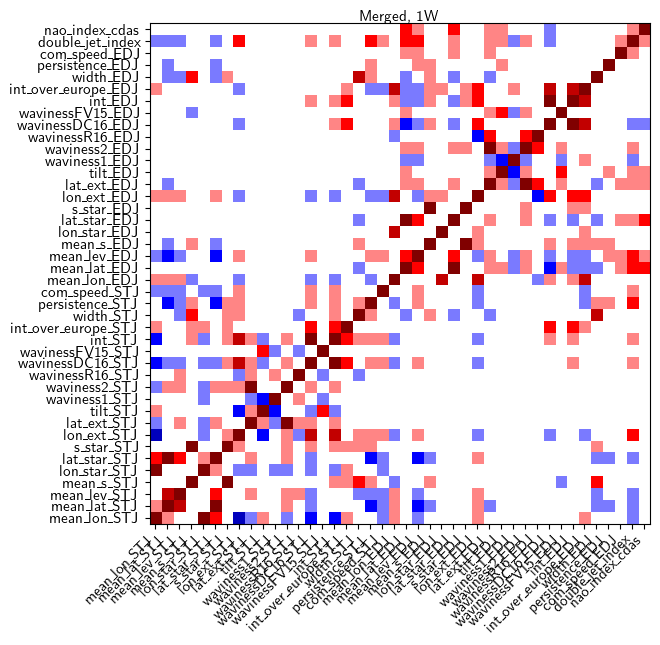

In [88]:
freq = "1W"
columns = props_pivoted.columns[1:]
props_pivoted_resampled = props_pivoted.group_by_dynamic("time", every="1w").agg([pl.col(col).mean() for col in columns])
X = props_pivoted_resampled.to_numpy()[:, 1:]
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title(f"Merged, {freq}")

Text(0.5, 1.0, 'Merged, 1M')

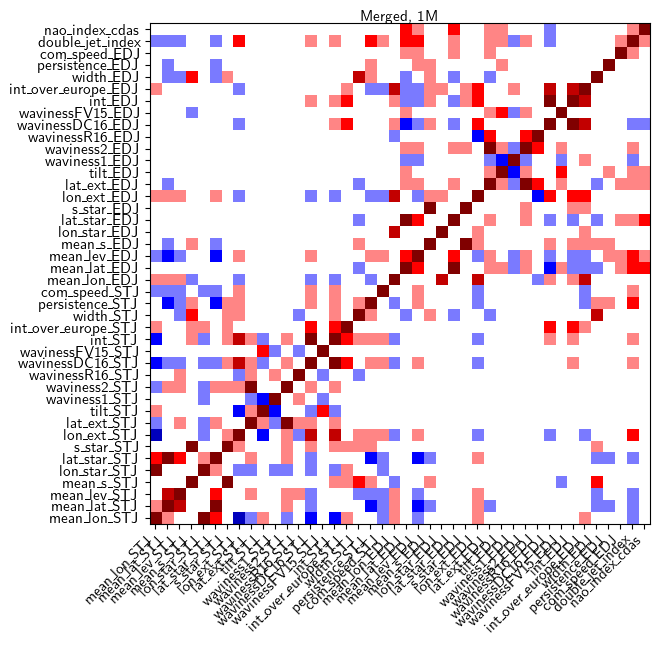

In [89]:
freq = "1M"
columns = props_pivoted.columns[1:]
props_pivoted_resampled = props_pivoted.group_by_dynamic("time", every="1w").agg([pl.col(col).mean() for col in columns])
X = props_pivoted_resampled.to_numpy()[:, 1:]
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title(f"Merged, {freq}")

Text(0.5, 1.0, 'Merged, 1Y')

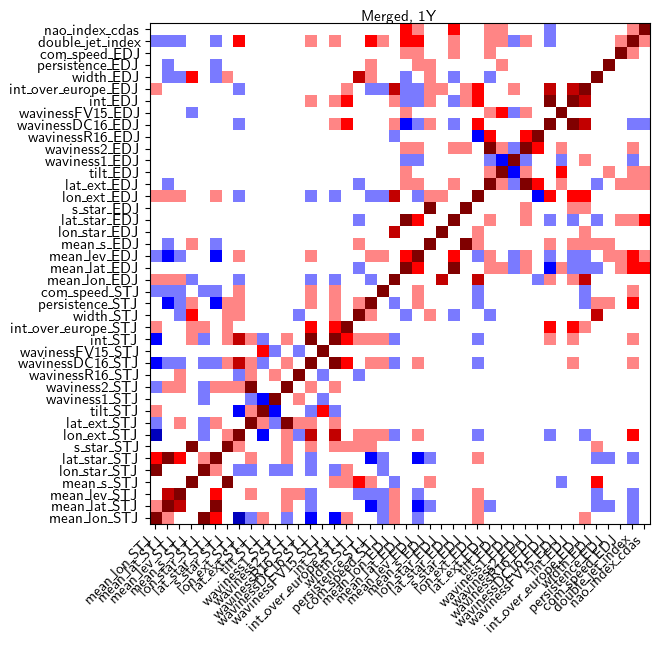

In [90]:
freq = "1Y"
columns = props_pivoted.columns[1:]
props_pivoted_resampled = props_pivoted.group_by_dynamic("time", every="1w").agg([pl.col(col).mean() for col in columns])
X = props_pivoted_resampled.to_numpy()[:, 1:]
X = X[~np.any(np.isnan(X), axis=1)]
corr_mat = np.corrcoef(X, rowvar=False)
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)
fig, ax = plt.subplots(figsize=(7, 6.5), subplot_kw={"aspect": "equal"})
im = ax.imshow(corr_mat, cmap=cmap, norm=norm, origin="lower")
ax.set_yticks(np.arange(0, len(columns)), columns)
_ = ax.set_xticks(
    np.arange(0, len(columns)),
    columns,
    rotation=45,
    ha="right",
)
ax.set_title(f"Merged, {freq}")

# Seasonal variability ?

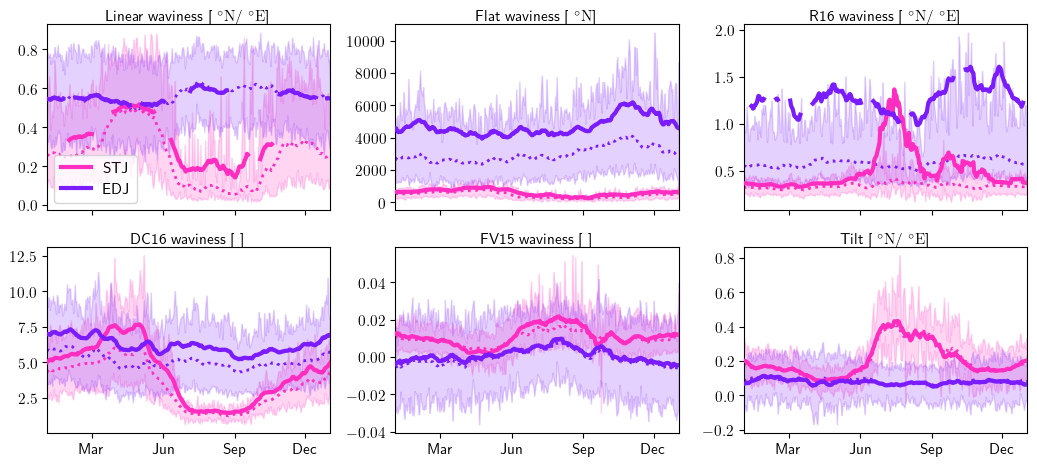

In [24]:
data_vars = [
    "waviness1",
    "waviness2",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "tilt",
]
plot_seasonal(props_as_df, data_vars, nrows=2, ncols=3, clear=False, suffix="_waviness")

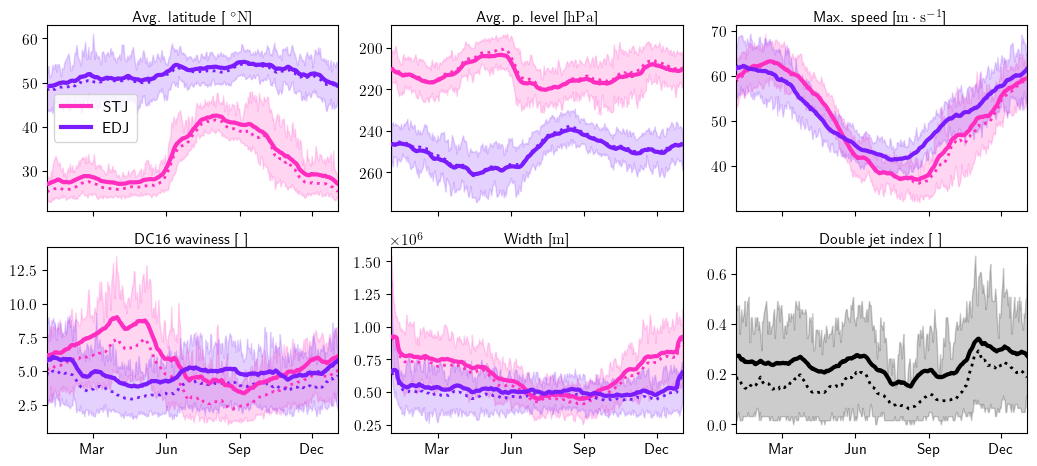

In [48]:
props_as_df = categorize_df_jets(props_as_df_uncat, polar_cutoff=0.9, allow_hybrid=False)
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
data_vars = [
    "mean_lat",
    "mean_lev",
    "s_star",
    "wavinessDC16",
    "width",
    "double_jet_index",
]
plot_seasonal(props_as_df, data_vars, nrows=2, ncols=3, clear=False, suffix="_subset_0.9")

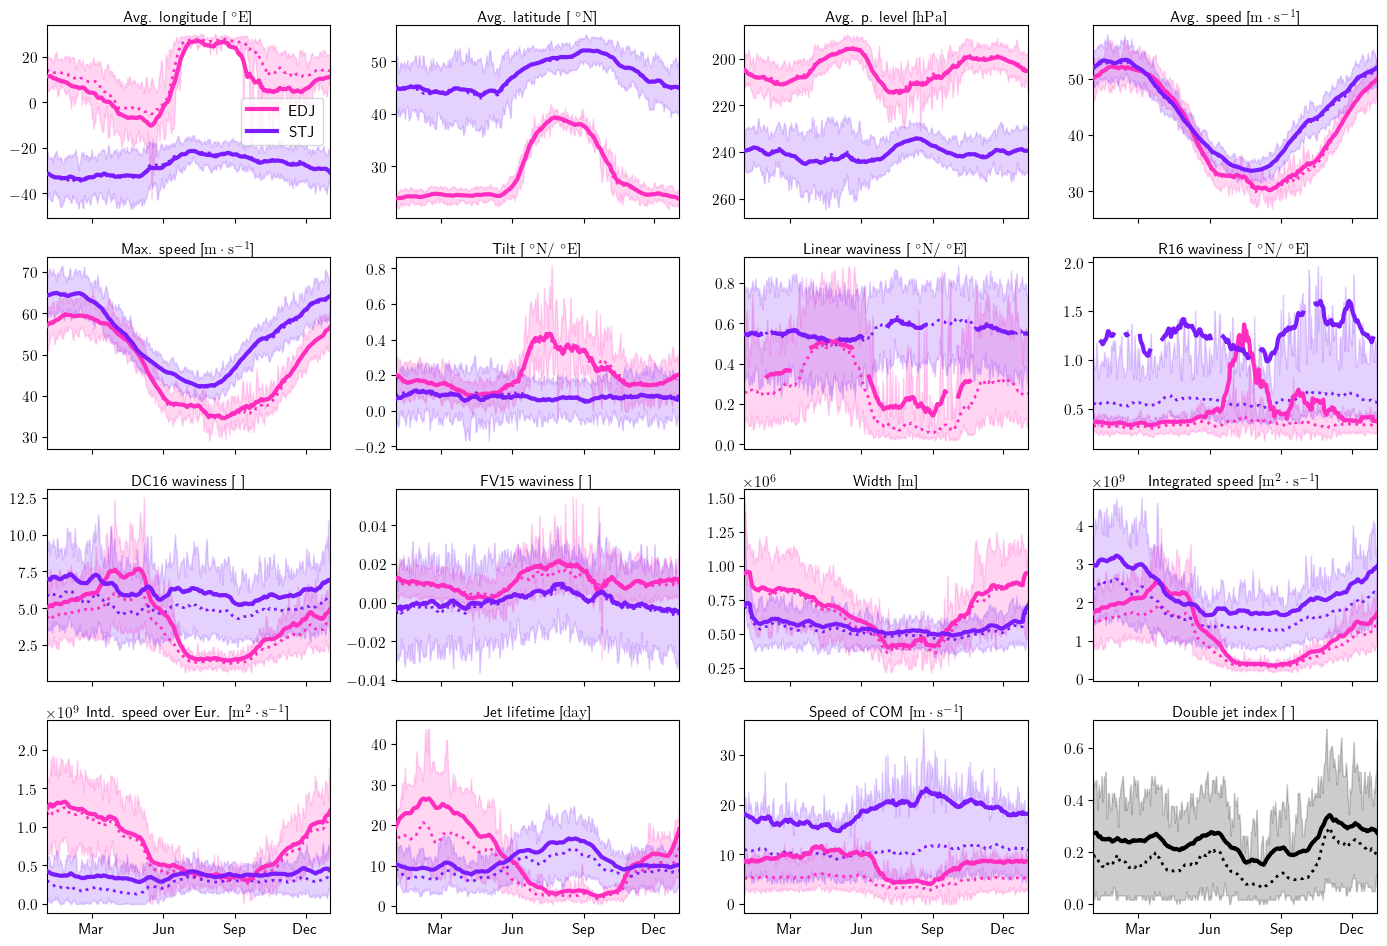

In [26]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
plot_seasonal(props_as_df, data_vars, nrows=4, ncols=4, clear=False)

# Dayofyear trend

In [ ]:
from matplotlib.dates import DateFormatter, MonthLocator

data_vars = [
    "mean_lon",
    "mean_lat",
    "s_star",
    "wavinessDC16",
    "width",
    "double_jet_index",
]
nrows = 2
ncols = 3
winsize = 60
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 3.5, nrows * 2.4), tight_layout=True, sharex="all"
)
axes = axes.flatten()

n_years = props_as_df["time"].dt.year().n_unique()
rng = np.random.default_rng()
n_bootstraps = 500
bootstrap_len = 4
num_blocks = n_years // bootstrap_len

sample_indices = rng.choice(n_years - bootstrap_len - 1, size=(n_bootstraps, n_years // bootstrap_len))
sample_indices = sample_indices[..., None] + np.arange(bootstrap_len)[None, None, :]
sample_indices = sample_indices.reshape(n_bootstraps, num_blocks * bootstrap_len)
sample_indices = np.append(sample_indices, np.arange(n_years)[None, :], axis=0)
sample_indices = sample_indices.flatten()

data_vars = [col for col in props_as_df.columns if col not in ["time", "jet", "year", "flag"]]
props_as_df_daily = props_as_df.group_by_dynamic(pl.col("time"), every="1d", group_by="jet").agg(**{data_var: pl.col(data_var).mean() for data_var in data_vars}).sort([pl.col("time"), pl.col("jet")])
props_as_df_daily = props_as_df_daily.filter(pl.col("time").dt.ordinal_day() < 366)
ts_bootstrapped = props_as_df_daily.group_by([pl.col("time").dt.ordinal_day().alias("dayofyear"), pl.col("jet")], maintain_order=True).agg(
    **{data_var: pl.col(data_var).gather(sample_indices) for data_var in data_vars}, 
    year=pl.col("time").dt.year().gather(sample_indices), 
    inside_index=pl.int_range(len(sample_indices)) % 64,
    sample_index=pl.int_range(len(sample_indices)) // 64,
).explode([*data_vars, "year", "inside_index", "sample_index"])
slopes = ts_bootstrapped.group_by(["dayofyear", "sample_index", "jet"], maintain_order=True).agg(**{data_var: pl.col(data_var).least_squares.ols(pl.col("inside_index"), mode="coefficients", add_intercept=True, null_policy="drop").struct.field("inside_index") for data_var in data_vars})
pvals = slopes.group_by(["dayofyear", "jet"], maintain_order=True).agg(**{data_var: pl.col(data_var).head(n_bootstraps).sort().search_sorted(pl.col(data_var).get(-1)) / n_bootstraps for data_var in data_vars})

ys = slopes.filter(pl.col("sample_index") == n_bootstraps)
ys = periodic_rolling_pl(ys, winsize, data_vars)

for varname, ax in zip(data_vars, axes.ravel()):
    dji = varname == "double_jet_index"
    if varname == "mean_lev":
        ax.invert_yaxis()
    ax.set_title(
        f"{PRETTIER_VARNAME.get(varname, varname)} [{UNITS.get(varname, '')}]"
    )
    dji = varname == "double_jet_index"
    for i, jet in enumerate(["STJ", "EDJ"]):
        color = "black" if dji else COLORS[2 - i]
        y = ys.filter(pl.col("jet") == jet)[varname]
        ps = pvals.filter(pl.col("jet") == jet)[varname]
        x = np.arange(len(y))
        ax.plot(x, y, lw=2, color=color, label=jet, zorder=10)
        filter_ = (ps > 0.975) | (ps < 0.025)
        ax.scatter(
            x[filter_],
            y.filter(filter_),
            marker=".",
            color=color,
            s=60,
            linewidths=2,
            zorder=11,
        )
        if dji:
            break
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS.get(varname, '1')}/year]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim)
    ax.grid(True)
axes.ravel()[0].legend().set_zorder(102)
plt.savefig(f"{FIGURES}/jet_props_misc/dayofyear_trends_{winsize=}.png")